In [1]:
# import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import sklearn
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.functions import sum, mean

spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)


21/11/18 23:52:16 WARN Utils: Your hostname, DESKTOP-NEDG45B resolves to a loopback address: 127.0.1.1; using 172.26.202.64 instead (on interface eth0)
21/11/18 23:52:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/18 23:52:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
sdf = spark.read.parquet('../data/aggregated_results1.parquet/')

# it takes too long to "groupby" first and then 'count', 'group by' again and then 'aggregate'
# so I choose to derive the number of instances for each group from the aggregated results
sdf = sdf.withColumn("count", F.round(col("sum_fare_amount") / col("avg_fare_amount"),0))

sdf.limit(20)

PULocationID,Month,weekday,hour,sum_fare_amount,avg_fare_amount,total_trip_distance,total_duration,count
113,11,6,0,7854.2,12.486804451510334,1809.3000000000002,515852,629.0
189,11,6,1,77.0,12.833333333333334,19.83,4512,6.0
87,11,6,5,2186.5,23.766304347826086,707.8000000000001,83505,92.0
209,11,6,5,560.5,28.025,175.60999999999999,104845,20.0
227,11,6,7,26.5,13.25,7.58,1428,2.0
247,11,6,7,85.0,17.0,24.6,5025,5.0
170,11,6,13,25239.4,12.870678225395208,4545.490000000001,2356674,1961.0
145,11,6,13,1321.5,30.732558139534884,145.97,70626,43.0
35,11,6,13,40.0,13.333333333333334,10.600000000000001,2349,3.0
140,11,6,16,12798.499999999998,11.336138175376437,2402.780000000001,1143956,1129.0


In [4]:
sdf.count()

360640

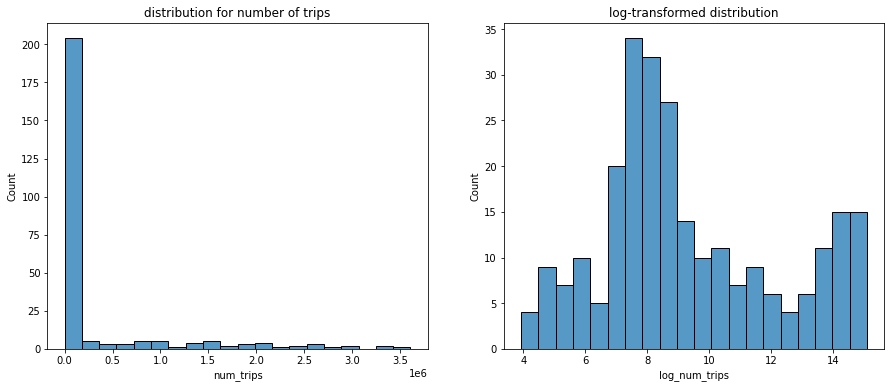

In [5]:
pu_location_sdf = sdf.groupBy("PULocationID").agg(
                    sum("count").alias("num_trips"),
                    sum("total_duration").alias("total_duration"),
                    sum('total_trip_distance').alias('total_trip_distance'),
                    sum('sum_fare_amount').alias("sum_fare_amount"))

# further drive and extract data given the aggregated results
pu_location_sdf = pu_location_sdf.withColumn("avg_time", col("total_duration") / col("num_trips")) \
        .withColumn("avg_trip_distance", col("total_trip_distance") / col("num_trips")) \
        .withColumn("avg_fare_amount", col("sum_fare_amount") / col("num_trips")) \
        .withColumn("avg_fare_amount_per_30mins", col("sum_fare_amount") * 1800 / col("total_duration"))
# add a column to indicate profitability of a zone

pu_location_sdf = pu_location_sdf.drop("total_duration", "total_trip_distance","sum_fare_amount")

# pu_location_sdf.limit(5)

pu_location_df = pu_location_sdf.toPandas()
# filtered out those zones which has less than 50 trips throughout entire 2017
pu_location_df = pu_location_df.loc[pu_location_df['num_trips']>50]
pu_location_df["log_num_trips"] = np.log(pu_location_df["num_trips"])


# have a look at the distribution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.histplot(pu_location_df['num_trips'],bins=20, ax=ax1).set_title("distribution for number of trips")
sns.histplot(pu_location_df['log_num_trips'],bins=20, ax=ax2).set_title("log-transformed distribution")
plt.savefig("../plots/dist_compare.png")

In [6]:
import geopandas as gpd

'''
code in this section made reference to Akira's tutorial
https://github.com/akiratwang/MAST30034_Python/blob/main/tutorials/Lab2_Python.ipynb

'''


sf = gpd.read_file("../data/taxi_zones/taxi_zones.shp")
zone = pd.read_csv("../data/taxi_zones/taxi+_zone_lookup.csv")

sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

gdf = gpd.GeoDataFrame(pd.merge(pu_location_df, sf, left_on='PULocationID', right_on='LocationID')) \
                        .drop('LocationID',axis=1)


## Code to generate plots are shown below

In [7]:
import folium
geoJSON = gdf[['PULocationID','geometry','zone']].to_json()
# function to creat geo map
def get_geomap(field, legend):
    m = folium.Map(location=[40.66, -73.94], zoom_start=10, tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m) # hide the tiles

    folium.Choropleth(
        geo_data=geoJSON,
        name="choropleth",
        data=gdf,
        columns=["PULocationID", field],
        key_on="properties.PULocationID",
        fill_color="OrRd",
        fill_opacity=0.9,
        line_opacity=0.5,
        legend_name= legend,
    ).add_to(m)

    # add labels for each zone as another layer to the map so that the map becomes interactive now
    # specify the setting
    style_function = lambda x: {'fillColor': '#ffffff', 
                                'color':'#000000', 
                                'fillOpacity': 0.1, 
                                'weight': 0.1}
    highlight_function = lambda x: {'fillColor': '#000000', 
                                    'color':'#000000', 
                                    'fillOpacity': 0.50, 
                                    'weight': 0.1}
    labels = folium.features.GeoJson(
        gdf,
        style_function=style_function, 
        control=False,
        highlight_function=highlight_function, 
        tooltip=folium.features.GeoJsonTooltip(
            fields=['zone',field],
            aliases=['District: ',field],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 10px; padding: 8px;") 
        )
    )
    m.add_child(labels)
    m.keep_in_front(labels)
    folium.LayerControl().add_to(m)
    fpth = "../plots/" + field + ".html"
    print(fpth)
    m.save(fpth)



In [8]:
# plot for number of trips at each zone
get_geomap("log_num_trips", "log(# trips)")

../plots/log_num_trips.html


In [9]:
pu_location_df.head()

,PULocationID,num_trips,avg_time,avg_trip_distance,avg_fare_amount,avg_fare_amount_per_30mins,log_num_trips
0,148,1020468.0,1127.221377,2.912403,12.648024,20.196959,13.835772
1,243,14535.0,1195.222016,4.051180,18.646323,28.081294,9.584315
2,31,471.0,1824.131635,6.571932,28.230042,27.856584,6.154858
3,137,980845.0,918.071740,2.270963,10.862071,21.296515,13.796170
4,251,107.0,2464.457944,10.868879,48.037944,35.086133,4.672829


In [10]:
# plot for average trip time, distance, fare amount and profitability for each zone 
get_geomap("avg_time", "trip_time in seconds")

../plots/avg_time.html


In [11]:
get_geomap("avg_trip_distance", "average trip_distance (in miles)")

../plots/avg_trip_distance.html


In [12]:
get_geomap("avg_fare_amount", "average fare amount for a single trip ($)")

../plots/avg_fare_amount.html


In [13]:
# here we remove the trips start from Newark Airport which appears to be an outlier
pu_location_df = pu_location_df.loc[pu_location_df["PULocationID"]!=1]
pu_location_df = pu_location_df.loc[pu_location_df["PULocationID"]!=30]
gdf = gpd.GeoDataFrame(pd.merge(pu_location_df, sf, left_on='PULocationID', right_on='LocationID')) \
                        .drop('LocationID',axis=1)
geoJSON = gdf[['PULocationID','geometry','zone']].to_json()
get_geomap("avg_fare_amount_per_30mins", "fare_income/30mins($)")


../plots/avg_fare_amount_per_30mins.html


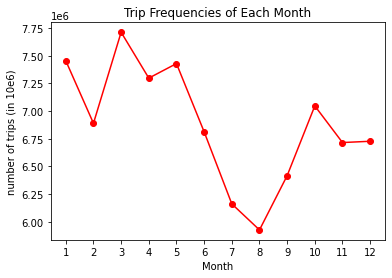

In [17]:
month_trip_df = sdf.groupBy("Month").agg(sum("count").alias("trip_num")) \
                    .toPandas().sort_values(by="Month")


ax1 = plt.plot(month_trip_df.Month, month_trip_df.trip_num, color="red", Marker='o')
title = "Trip Frequencies of Each Month"
plt.xticks(month_trip_df.Month)
plt.title(title)
plt.ylabel("number of trips (in 10e6)")
plt.xlabel("Month")
plt.savefig("../plots/month_trip.png", bbox_inches = "tight")
plt.show()

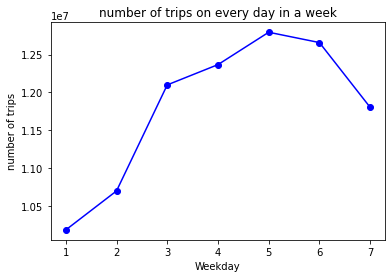

In [15]:
weekday_trip_df = sdf.groupBy("weekday").agg(sum("count").alias("trip_num")) \
                    .toPandas().sort_values(by="weekday")


ax1 = plt.plot(weekday_trip_df.weekday, weekday_trip_df.trip_num, color="blue", Marker='o')
title = "number of trips on every day in a week"
plt.xticks(weekday_trip_df.weekday)
plt.title(title)
plt.ylabel("number of trips")
plt.xlabel("Weekday")
plt.savefig("../plots/weekday_trip.png", bbox_inches = "tight")

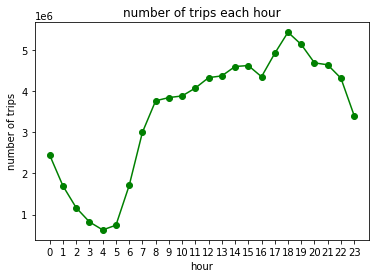

In [16]:
hourly_trip_df = sdf.groupBy("hour").agg(sum("count").alias("trip_num")) \
                    .toPandas().sort_values(by="hour")


ax1 = plt.plot(hourly_trip_df.hour, hourly_trip_df.trip_num, color="green", Marker='o')
title = "number of trips each hour"
plt.xticks(hourly_trip_df.hour)
plt.title(title)
plt.ylabel("number of trips")
plt.xlabel("hour")
plt.savefig("../plots/hour_trip.png", bbox_inches = "tight")